In [1]:
from utils.read_data import DataConverter

import os
import random
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# !pip install xmltodict

# Approach

    1. Crop the image into 64 x 64 data such that it contains the correct bounding box
        a. First check if the bounding boxes can fit into 64 x 64
        b. to do this, check the box max(width) - min(width) < 64, max(heights) - min(heights) < 64
        c. After confirming that, crop the image with the average(x_center, y_center) as center to be 64 by 64
        

## A. Quick test

In [2]:
project_path = '/home/gj2353/e6998-5_final_project/'

In [3]:
imgsz = 32

In [57]:
os.mkdir(os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/"))
os.mkdir(os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/images/"))
os.mkdir(os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/labels/"))


os.mkdir(os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/"))
os.mkdir(os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/images/"))
os.mkdir(os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/labels/"))

os.mkdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/"))
os.mkdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/"))
os.mkdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/labels/"))

In [56]:
# # shutil.rmtree(os.path.join(project_path, "data/google_digit_data/train_cropped/"))
# # shutil.rmtree(os.path.join(project_path, "data/google_digit_data/test_cropped/"))
# # shutil.rmtree(os.path.join(project_path, "data/google_digit_data/valid_cropped/"))

# shutil.rmtree(os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/"))
# shutil.rmtree(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/"))
# shutil.rmtree(os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/"))


In [63]:
folder_name = 'valid'
imgs = os.listdir(os.path.join(project_path, f"data/google_digit_data/{folder_name}/images/"))

In [64]:
for img in imgs:
    image = Image.open(os.path.join(project_path, f"data/google_digit_data/{folder_name}/images/{img}"))
    image_arr = np.array(image)
    
    # get the corresponding annotation
    with open(os.path.join(project_path, f"data/google_digit_data/{folder_name}/labels/{img.split('.')[0]}.txt"), "r") as f:        
        sample_annotation = f.read().split('\n')[:-1]
        f.close()
    
    img_height = image_arr.shape[0]
    img_width = image_arr.shape[1]

    # process sample annotations
    cls = [float(i.split(' ')[0]) for i in sample_annotation]
    x_coords = [float(i.split(' ')[1])*img_width for i in sample_annotation]
    y_coords = [float(i.split(' ')[2])*img_height for i in sample_annotation]
    widths = [float(i.split(' ')[3])*img_width for i in sample_annotation]
    heights = [float(i.split(' ')[4])*img_height for i in sample_annotation]
        
        
    # for each image, get the minimum x and minimum y 
    x_min_loc=np.inf
    x_max_loc=0
    y_min_loc=np.inf
    y_max_loc=0

    new_img_width=imgsz
    new_img_height=imgsz

    for i in range(0, len(x_coords)):

        x_min = x_coords[i] - widths[i]/2
        x_max = x_coords[i] + widths[i]/2
        y_min = y_coords[i] - heights[i]/2
        y_max = y_coords[i] + heights[i]/2

        if x_min < x_min_loc:
            x_min_loc = x_min

        if x_max > x_max_loc:
            x_max_loc = x_max

        if y_min < y_min_loc:
            y_min_loc = y_min

        if y_max > y_max_loc:
            y_max_loc = y_max
            

    # check if cropping is going to cut off max width and height necessary for bounding boxes
    # also eliminate case where black borders will be produced
    # (x_min_loc + new_img_width < img_width) and (y_min_loc + new_img_height < img_height):

    x_min_loc = x_min_loc - 5
    y_min_loc = y_min_loc - 5
    
    if (x_min_loc + new_img_width > x_max_loc) and (y_min_loc + new_img_height > y_max_loc) and (x_min_loc > 0) and (y_min_loc > 0) and (x_min_loc + new_img_width < img_width+5) and (y_min_loc + new_img_height < img_height+5):

        new_ann = []
        # crop the image and save to the new folder
        test_image_new = image.crop((x_min_loc, y_min_loc, x_min_loc+new_img_width, y_min_loc+new_img_height))
        test_image_new.save(os.path.join(project_path, f"data/google_digit_data/{folder_name}_cropped_{imgsz}/images/{img}"), 'png')
        
        # create a new annotation file
        with open(os.path.join(project_path, f"data/google_digit_data/{folder_name}_cropped_{imgsz}/labels/{img.split('.')[0]}.txt"), 'w') as f:
            f.close()
        
        # reset the bounding boxes
        for i in range(0, len(x_coords)):
            new_x_prop = (x_coords[i]-x_min_loc)/((x_min_loc+new_img_width)-x_min_loc)
            new_y_prop = (y_coords[i]-y_min_loc)/((y_min_loc+new_img_height)-y_min_loc)
            new_width = widths[i]/new_img_width
            new_height = heights[i]/new_img_height

            with open(os.path.join(project_path, f"data/google_digit_data/{folder_name}_cropped_{imgsz}/labels/{img.split('.')[0]}.txt"), 'a') as f:
                f.write("{} {:.6f} {:.6f} {:.6f} {:.6f}\n".format(cls[i], new_x_prop, new_y_prop, new_width, new_height))


## Verify

In [65]:
print(len(os.listdir(os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/images/"))))
print(len(os.listdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/"))))
print(len(os.listdir(os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/images/"))))

2464
4265
243


In [70]:
sample = os.listdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/"))[0]

In [72]:
test_image = Image.open(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/{sample}"))

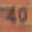

In [73]:
test_image

In [75]:
with open(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/labels/{sample.split('.')[0]}.txt"), "r") as f:
    sample_annotation = f.read()
    f.close()
    
height=imgsz
width=imgsz
  
updated_annotation = []
for i in sample_annotation.split('\n')[:-1]:
    
    temp = i.split(' ')
    print(temp)
    temp[1] = round(float(temp[1]) * width)
    temp[2] = round(float(temp[2]) * height)
    temp[3] = round(float(temp[3]) * width)
    temp[4] = round(float(temp[4]) * height)
    
    # x min
    x_min = int(temp[1]-temp[3]/2)
    x_max = int(temp[1]+temp[3]/2)
    y_min = int(temp[2]-temp[4]/2)
    y_max = int(temp[2]+temp[4]/2)
    
    updated_annotation.append([temp[0], x_min,x_max,y_min,y_max])

['4.0', '0.328126', '0.453125', '0.343751', '0.593750']
['0.0', '0.718752', '0.515626', '0.374999', '0.593750']


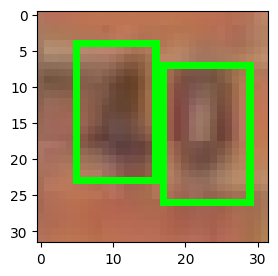

In [76]:
plt.subplots(figsize=(3,3))
test_image_arr = np.array(test_image)
for i in updated_annotation:
    cv2.rectangle(test_image_arr, pt1=(i[1],i[4]), pt2=(i[2],i[3]), color=(0,255,0), thickness=1)
plt.imshow(test_image_arr)


## Move images to train

In [4]:
print(len(os.listdir(os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/images/"))))
print(len(os.listdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/"))))
print(len(os.listdir(os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/images/"))))

5251
0
1504


In [8]:
test_imgs = sorted(os.listdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/")))
test_labs = sorted(os.listdir(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/labels/")))

print(test_imgs[0])
print(test_labs[0])

10.png
10.txt


In [9]:
test_imgs = [i for i in test_imgs if '.png' in i]
test_labs = [i for i in test_labs if '.txt' in i]

In [10]:
for i in test_imgs[:3000]:
    shutil.move(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/{i}"),
                os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/images/{i}"),
               )
    
    lab = i.split('.')[0] + '.txt'
    
    shutil.move(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/labels/{lab}"),
                os.path.join(project_path, f"data/google_digit_data/train_cropped_{imgsz}/labels/{lab}"),
               )

In [11]:
for i in test_imgs[3000:]:
    shutil.move(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/images/{i}"),
                os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/images/{i}"),
               )
    
    lab = i.split('.')[0] + '.txt'
    
    shutil.move(os.path.join(project_path, f"data/google_digit_data/test_cropped_{imgsz}/labels/{lab}"),
                os.path.join(project_path, f"data/google_digit_data/valid_cropped_{imgsz}/labels/{lab}"),
               )